### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
       

        from_folder = "../ge_data/nodule"
        
        image_path = f"{from_folder}/images/{image_name}"
        nodule_mask_path = f"{from_folder}/true_nodule_masks/{mask_name}"
        gland_mask_path = f"{from_folder}/inference_gland(wo_nodule)_masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        nodule_mask = Image.open(nodule_mask_path).convert("L")
        gland_mask = Image.open(gland_mask_path).convert("L")
        
        image_tensor, nodule_mask_tensor, gland_mask_tensor = self.transform(image, nodule_mask, gland_mask, self.image_size)
        nodule_mask_tensor = (nodule_mask_tensor > 0.5).float()
        gland_mask_tensor = (gland_mask_tensor > 0.5).float()
        
        if torch.sum(nodule_mask_tensor) == 0 or torch.sum(gland_mask_tensor) == 0:
            return [None]
        return image_tensor, nodule_mask_tensor, gland_mask_tensor

In [5]:
image_size = 128
batch_size = 256
def train_augmentation(image, nodule_mask, gland_mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    nodule_mask = resize(nodule_mask)
    gland_mask = resize(gland_mask)

    p = 0.9
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        nodule_mask = F.affine(nodule_mask, angle=angle, translate=translate, scale=scale, shear=shear)
        gland_mask = F.affine(gland_mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    nodule_mask_tensor = tx.to_tensor(nodule_mask)
    gland_mask_tensor = tx.to_tensor(gland_mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, nodule_mask_tensor, gland_mask_tensor
def test_augmentation(image, nodule_mask, gland_mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    nodule_mask = resize(nodule_mask)
    gland_mask = resize(gland_mask)
        
    image_tensor = tx.to_tensor(image)
    nodule_mask_tensor = tx.to_tensor(nodule_mask)
    gland_mask_tensor = tx.to_tensor(gland_mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, nodule_mask_tensor, gland_mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Dataset("../ge_data/nodule/new_train.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Dataset("../ge_data/nodule/new_test.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn=custom_collate_fn)

image, nodule_mask, gland_mask = next(iter(test_dataloader))

In [6]:
image.shape

torch.Size([1, 1, 128, 128])

In [7]:
print(len(train_dataset), len(test_dataset))

576 101


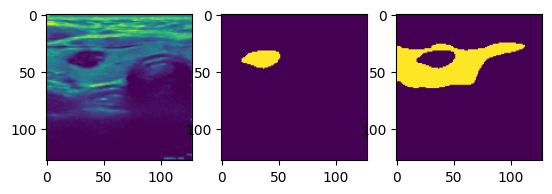

In [8]:
index = 0
plt.subplot(1,3,1)
plt.imshow(image[index][0])
plt.subplot(1,3,2)
plt.imshow(nodule_mask[index][0])
plt.subplot(1,3,3)
plt.imshow(gland_mask[index][0])

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0


    total_nodule_IOU = 0
    total_nodule_DICE = 0

    total_gland_IOU = 0
    total_gland_DICE = 0

    
    model.train()
    model.to(device)


    
    count = 0
    for image, nodule_mask, gland_mask in tqdm(dataloader):
        if image == None:
            continue
        image, nodule_mask, gland_mask = image.to(device), nodule_mask.to(device), gland_mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        nodule_loss = loss_fn(nodule_output, nodule_mask)
        gland_loss = loss_fn(gland_output, gland_mask)
        loss = (nodule_loss + gland_loss) / 2

        nodule_IOU = IOU_score(nodule_output, nodule_mask)
        gland_IOU = IOU_score(gland_output, gland_mask)
        IOU = (nodule_IOU + gland_IOU) / 2

        dice_loss = DiceLoss()
        nodule_DICE = 1 - dice_loss(nodule_output, nodule_mask)
        gland_DICE = 1 - dice_loss(gland_output, gland_mask)
        DICE = (nodule_DICE + gland_DICE) / 2
        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_nodule_IOU += nodule_IOU
        total_nodule_DICE += nodule_DICE
        total_gland_IOU += gland_IOU
        total_gland_DICE += gland_DICE
        
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_nodule_IOU / count, total_nodule_DICE / count, total_gland_IOU / count, total_gland_DICE / count

# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_nodule_IOU = 0
    total_nodule_DICE = 0

    total_gland_IOU = 0
    total_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, nodule_mask, gland_mask in tqdm(dataloader):
        if image == None:
            continue
        image, nodule_mask, gland_mask = image.to(device), nodule_mask.to(device), gland_mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        nodule_loss = loss_fn(nodule_output, nodule_mask)
        gland_loss = loss_fn(gland_output, gland_mask)
        loss = (nodule_loss + gland_loss) / 2

        nodule_IOU = IOU_score(nodule_output, nodule_mask)
        gland_IOU = IOU_score(gland_output, gland_mask)
        IOU = (nodule_IOU + gland_IOU) / 2

        dice_loss = DiceLoss()
        nodule_DICE = 1 - dice_loss(nodule_output, nodule_mask)
        gland_DICE = 1 - dice_loss(gland_output, gland_mask)
        DICE = (nodule_DICE + gland_DICE) / 2
        

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_nodule_IOU += nodule_IOU
        total_nodule_DICE += nodule_DICE
        total_gland_IOU += gland_IOU
        total_gland_DICE += gland_DICE
        
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_nodule_IOU / count, total_nodule_DICE / count, total_gland_IOU / count, total_gland_DICE / count

    

In [10]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [11]:
# # freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [12]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
weight_decay = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [13]:

project = "thyroid_ge(nodule_with_gland)_from_scratch"
name = f"hybrid_model_ge(nodule_with_gland(wo_nodule))_from_scratch_v1_aug_space(0.9)_weight_decay({weight_decay})"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "augmentation" : "aug_space(0.9)",
        "weight_decay": weight_decay
    }
)

In [14]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 500, batch size : 256


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, total_nodule_IOU_train, total_nodule_DICE_train, total_gland_IOU_train, total_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, total_nodule_IOU_val, total_nodule_DICE_val, total_gland_IOU_val, total_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge(nodule_with_gland)/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/from_scratch/ge(nodule_with_gland)/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_nodule_IOU" : total_nodule_IOU_train,
        "train_nodule_DICE" : total_nodule_DICE_train,
        "train_gland_IOU" : total_gland_IOU_train,
        "train_gland_DICE" : total_gland_DICE_train,
        
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_nodule_IOU" : total_nodule_IOU_val,
        "val_nodule_DICE" : total_nodule_DICE_val,
        "val_gland_IOU" : total_gland_IOU_val,
        "val_gland_DICE" : total_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/from_scratch/ge(nodule_with_gland)/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 3/3 [00:07<00:00,  2.64s/it]


train loss : 1.3069239457448323, train IOU : 0.12443364163239796, train DICE : 0.21052366495132446


100%|██████████| 101/101 [00:02<00:00, 37.60it/s]


val loss : 1.1287623325196823, val IOU : 0.046057652944571564, val DICE : 0.21511150557215852
epoch : 1


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 1.0546668767929077, train IOU : 0.027200939832255244, train DICE : 0.2615368068218231


100%|██████████| 101/101 [00:02<00:00, 38.54it/s]


val loss : 1.0759493124366988, val IOU : 0.09497091296598698, val DICE : 0.2543756634292036
epoch : 2


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.943582276503245, train IOU : 0.22529197235902151, train DICE : 0.36705003182093304


100%|██████████| 101/101 [00:02<00:00, 44.65it/s]


val loss : 0.9982552044462449, val IOU : 0.30490570235075337, val DICE : 0.3651306962612832
epoch : 3


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.8586522539456686, train IOU : 0.3815544943014781, train DICE : 0.4656342069307963


100%|██████████| 101/101 [00:02<00:00, 40.85it/s]


val loss : 0.9014884168558782, val IOU : 0.3573276794487887, val DICE : 0.4222088860403193
epoch : 4


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.8180458943049113, train IOU : 0.3893292744954427, train DICE : 0.4947015742460887


100%|██████████| 101/101 [00:02<00:00, 44.37it/s]


val loss : 0.8997703619522623, val IOU : 0.37249693717106735, val DICE : 0.45042909312956403
epoch : 5


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.7858670155207316, train IOU : 0.4244450032711029, train DICE : 0.5316273172696432


100%|██████████| 101/101 [00:02<00:00, 44.59it/s]


val loss : 1.0072235394232343, val IOU : 0.2931045895755881, val DICE : 0.39514631977175724
epoch : 6


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.7684334516525269, train IOU : 0.43004762132962543, train DICE : 0.5479874412218729


100%|██████████| 101/101 [00:02<00:00, 44.78it/s]


val loss : 0.9367957392541488, val IOU : 0.3301116017126801, val DICE : 0.4186928838786512
epoch : 7


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.7391063570976257, train IOU : 0.44626497228940326, train DICE : 0.5542484521865845


100%|██████████| 101/101 [00:02<00:00, 44.81it/s]


val loss : 0.8479297231919695, val IOU : 0.3818205161259906, val DICE : 0.4781313933948479
epoch : 8


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.733456015586853, train IOU : 0.45139798521995544, train DICE : 0.5736128091812134


100%|██████████| 101/101 [00:02<00:00, 44.51it/s]


val loss : 0.7939168326925523, val IOU : 0.4155860040152427, val DICE : 0.5000630652550424
epoch : 9


100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


train loss : 0.7189727822939554, train IOU : 0.4468483527501424, train DICE : 0.5646281838417053


100%|██████████| 101/101 [00:02<00:00, 44.30it/s]


val loss : 1.053314792047633, val IOU : 0.2882381353047815, val DICE : 0.39616226972919877
epoch : 10


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.7227561473846436, train IOU : 0.45282792051633197, train DICE : 0.5833588639895121


100%|██████████| 101/101 [00:02<00:00, 44.77it/s]


val loss : 0.8627540038363768, val IOU : 0.3856729738192983, val DICE : 0.49351467738057125
epoch : 11


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.6828603148460388, train IOU : 0.47743786374727887, train DICE : 0.6021607915560404


100%|██████████| 101/101 [00:02<00:00, 43.93it/s]


val loss : 0.8202593848846926, val IOU : 0.4041440594609421, val DICE : 0.5053723758400077
epoch : 12


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.6759068965911865, train IOU : 0.4818292061487834, train DICE : 0.613856573899587


100%|██████████| 101/101 [00:02<00:00, 44.23it/s]


val loss : 1.051054609293985, val IOU : 0.2895719678242608, val DICE : 0.4083650230181099
epoch : 13


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.6814607580502828, train IOU : 0.4729530413945516, train DICE : 0.6009716987609863


100%|██████████| 101/101 [00:02<00:00, 44.58it/s]


val loss : 0.9131905336191158, val IOU : 0.3518414353527645, val DICE : 0.4652518025129148
epoch : 14


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.6611170371373495, train IOU : 0.49149608612060547, train DICE : 0.6195271809895834


100%|██████████| 101/101 [00:02<00:00, 44.61it/s]


val loss : 0.7679992138159157, val IOU : 0.43363361414706353, val DICE : 0.5341444720726202
epoch : 15


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.6489481528600057, train IOU : 0.4984075625737508, train DICE : 0.6291840473810831


100%|██████████| 101/101 [00:02<00:00, 40.50it/s]


val loss : 0.8596983906066064, val IOU : 0.39404445451380005, val DICE : 0.4967724019938176
epoch : 16


100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


train loss : 0.6385842363039652, train IOU : 0.5066487789154053, train DICE : 0.6400723854700724


100%|██████████| 101/101 [00:02<00:00, 44.55it/s]


val loss : 0.9356985546574734, val IOU : 0.3588422718319562, val DICE : 0.47791527167405234
epoch : 17


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.6271865169207255, train IOU : 0.5134416619936625, train DICE : 0.6404542525609335


100%|██████████| 101/101 [00:02<00:00, 44.49it/s]


val loss : 0.7414935119081252, val IOU : 0.452894993495233, val DICE : 0.5640790382824322
epoch : 18


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.648635745048523, train IOU : 0.49384890993436176, train DICE : 0.6372657616933187


100%|██████████| 101/101 [00:02<00:00, 44.31it/s]


val loss : 0.8054333181664495, val IOU : 0.42110695874336923, val DICE : 0.532238123145434
epoch : 19


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.6360266208648682, train IOU : 0.5240497390429179, train DICE : 0.65956711769104


100%|██████████| 101/101 [00:02<00:00, 44.58it/s]


val loss : 0.796555917156805, val IOU : 0.4201238730756363, val DICE : 0.5298998597824928
epoch : 20


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.6316878994305929, train IOU : 0.5056102275848389, train DICE : 0.6415315270423889


100%|██████████| 101/101 [00:02<00:00, 44.65it/s]


val loss : 0.8318487597574101, val IOU : 0.4048930484764647, val DICE : 0.5237231897835685
epoch : 21


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.6198564171791077, train IOU : 0.5292221903800964, train DICE : 0.663893977801005


100%|██████████| 101/101 [00:02<00:00, 44.41it/s]


val loss : 0.7570428585652078, val IOU : 0.440234578334459, val DICE : 0.5504029511225106
epoch : 22


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.6097935438156128, train IOU : 0.5258658727010092, train DICE : 0.6631385684013367


100%|██████████| 101/101 [00:02<00:00, 44.48it/s]


val loss : 0.7509552438070278, val IOU : 0.44854702984932626, val DICE : 0.5609590762322492
epoch : 23


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.5829495787620544, train IOU : 0.5532530744870504, train DICE : 0.6817644635836283


100%|██████████| 101/101 [00:02<00:00, 44.24it/s]


val loss : 0.8263588411973255, val IOU : 0.4143124956748273, val DICE : 0.5291572579062811
epoch : 24


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.5699167052904764, train IOU : 0.5483543475468954, train DICE : 0.6854113737742106


100%|██████████| 101/101 [00:02<00:00, 44.27it/s]


val loss : 0.8065522752776004, val IOU : 0.44702100680016055, val DICE : 0.5717635603234319
epoch : 25


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.5742499033610026, train IOU : 0.5666560729344686, train DICE : 0.6922892332077026


100%|██████████| 101/101 [00:02<00:00, 44.57it/s]


val loss : 0.7087024960777547, val IOU : 0.4882442484250163, val DICE : 0.5959009141615121
epoch : 26


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.522389551003774, train IOU : 0.6017240683237711, train DICE : 0.7239240805308024


100%|██████████| 101/101 [00:02<00:00, 44.26it/s]


val loss : 0.6720142771702001, val IOU : 0.5177611209968529, val DICE : 0.6227256637988704
epoch : 27


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.5585306088129679, train IOU : 0.5700254042943319, train DICE : 0.708537737528483


100%|██████████| 101/101 [00:02<00:00, 40.38it/s]


val loss : 0.6917205175550858, val IOU : 0.4993439970335158, val DICE : 0.6065669334170842
epoch : 28


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.5689138372739156, train IOU : 0.555213471253713, train DICE : 0.69163978099823


100%|██████████| 101/101 [00:02<00:00, 44.63it/s]


val loss : 0.7174299344567969, val IOU : 0.4942072603372064, val DICE : 0.6068548973244016
epoch : 29


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.5455660422643026, train IOU : 0.58637003103892, train DICE : 0.7166757186253866


100%|██████████| 101/101 [00:02<00:00, 44.51it/s]


val loss : 0.7012776761952013, val IOU : 0.4814846633684517, val DICE : 0.5833097773023171
epoch : 30


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.5431165893872579, train IOU : 0.5748611489931742, train DICE : 0.7048032482465109


100%|██████████| 101/101 [00:02<00:00, 43.90it/s]


val loss : 0.7087089032819955, val IOU : 0.5041846168218272, val DICE : 0.6104430028117529
epoch : 31


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.5240069429079691, train IOU : 0.5949936111768087, train DICE : 0.725973109404246


100%|██████████| 101/101 [00:02<00:00, 43.44it/s]


val loss : 0.8043399674467521, val IOU : 0.44871760639223723, val DICE : 0.5647162243281261
epoch : 32


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.5113152861595154, train IOU : 0.6050529082616171, train DICE : 0.7321557601292928


100%|██████████| 101/101 [00:02<00:00, 44.65it/s]


val loss : 0.643290909210054, val IOU : 0.5260643045796026, val DICE : 0.6295656066129703
epoch : 33


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.5236210425694784, train IOU : 0.5935009519259135, train DICE : 0.7270001570383707


100%|██████████| 101/101 [00:02<00:00, 44.20it/s]


val loss : 0.7413071919195723, val IOU : 0.49033751257575386, val DICE : 0.6013193599658437
epoch : 34


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.5164210995038351, train IOU : 0.6117303768793741, train DICE : 0.7455661296844482


100%|██████████| 101/101 [00:02<00:00, 44.91it/s]


val loss : 0.6559443709873917, val IOU : 0.5238957335748294, val DICE : 0.6268717224645143
epoch : 35


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.47037490208943683, train IOU : 0.6249567270278931, train DICE : 0.7556352615356445


100%|██████████| 101/101 [00:02<00:00, 44.33it/s]


val loss : 0.6535820034470888, val IOU : 0.5325043949455318, val DICE : 0.6350853395934152
epoch : 36


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.46951302886009216, train IOU : 0.6461782455444336, train DICE : 0.7659280300140381


100%|██████████| 101/101 [00:02<00:00, 44.47it/s]


val loss : 0.7457027892665108, val IOU : 0.47466209530830383, val DICE : 0.5935521978552979
epoch : 37


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.47500014305114746, train IOU : 0.6262449026107788, train DICE : 0.7548699776331583


100%|██████████| 101/101 [00:02<00:00, 44.45it/s]


val loss : 0.6343769634714221, val IOU : 0.5461680977651389, val DICE : 0.6546017931829585
epoch : 38


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.46819016337394714, train IOU : 0.6463052829106649, train DICE : 0.7670943737030029


100%|██████████| 101/101 [00:02<00:00, 40.42it/s]


val loss : 0.6379379556320681, val IOU : 0.5418858821734344, val DICE : 0.649334871237821
epoch : 39


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.4567893048127492, train IOU : 0.6448563734690348, train DICE : 0.7741398413976034


100%|██████████| 101/101 [00:02<00:00, 45.26it/s]


val loss : 0.5996201101801183, val IOU : 0.5639232935586779, val DICE : 0.6663768241311064
epoch : 40


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.43125811219215393, train IOU : 0.6691445708274841, train DICE : 0.7836858431498209


100%|██████████| 101/101 [00:02<00:00, 44.63it/s]


val loss : 0.6797042155619895, val IOU : 0.5258401645587223, val DICE : 0.6432472370048561
epoch : 41


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.44625306129455566, train IOU : 0.6519835591316223, train DICE : 0.7771833141644796


100%|██████████| 101/101 [00:02<00:00, 44.53it/s]


val loss : 0.587999804480241, val IOU : 0.5782939152847423, val DICE : 0.6771683141146556
epoch : 42


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.4321141044298808, train IOU : 0.6684116323788961, train DICE : 0.7883614500363668


100%|██████████| 101/101 [00:02<00:00, 44.44it/s]


val loss : 0.5813043256207268, val IOU : 0.586416953713587, val DICE : 0.6898382158562688
epoch : 43


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.4309077064196269, train IOU : 0.6736741463343302, train DICE : 0.7920218706130981


100%|██████████| 101/101 [00:02<00:00, 44.32it/s]


val loss : 0.6141645318210716, val IOU : 0.5478310466992973, val DICE : 0.659309581659808
epoch : 44


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.4662567476431529, train IOU : 0.6577823162078857, train DICE : 0.7791555325190226


100%|██████████| 101/101 [00:02<00:00, 44.17it/s]


val loss : 0.6265786718023886, val IOU : 0.5366266347689204, val DICE : 0.6364758150412304
epoch : 45


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.45865166187286377, train IOU : 0.6498656272888184, train DICE : 0.770148773988088


100%|██████████| 101/101 [00:02<00:00, 45.12it/s]


val loss : 0.6146690686150352, val IOU : 0.5483647748680398, val DICE : 0.6528408338527868
epoch : 46


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.4348878065745036, train IOU : 0.6682018041610718, train DICE : 0.7906210422515869


100%|██████████| 101/101 [00:02<00:00, 44.22it/s]


val loss : 0.5503514640697158, val IOU : 0.6061280282712219, val DICE : 0.7066463589078129
epoch : 47


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.44250208139419556, train IOU : 0.667545219262441, train DICE : 0.7923679947853088


100%|██████████| 101/101 [00:02<00:00, 44.33it/s]


val loss : 0.679224967956543, val IOU : 0.513386485305163, val DICE : 0.6239368738514361
epoch : 48


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.4422598381837209, train IOU : 0.6588307619094849, train DICE : 0.786766509215037


100%|██████████| 101/101 [00:02<00:00, 44.44it/s]


val loss : 0.5971692192672503, val IOU : 0.5618687205680526, val DICE : 0.6682116610578971
epoch : 49


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.4364796578884125, train IOU : 0.6603292425473531, train DICE : 0.7790541251500448


100%|██████████| 101/101 [00:02<00:00, 40.62it/s]


val loss : 0.6267260867770356, val IOU : 0.5558251620519279, val DICE : 0.6643264332030079
epoch : 50


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.43157527844111127, train IOU : 0.6728587746620178, train DICE : 0.793192446231842


100%|██████████| 101/101 [00:02<00:00, 43.77it/s]


val loss : 0.5865257184694309, val IOU : 0.5717066746241976, val DICE : 0.673097834728732
epoch : 51


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.40962908665339154, train IOU : 0.6952513853708903, train DICE : 0.8005302349726359


100%|██████████| 101/101 [00:02<00:00, 44.85it/s]


val loss : 0.6095957390152582, val IOU : 0.5637151095831748, val DICE : 0.671602597626129
epoch : 52


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.39963192741076153, train IOU : 0.6893771886825562, train DICE : 0.8081824580828348


100%|██████████| 101/101 [00:02<00:00, 43.05it/s]


val loss : 0.5698720210849648, val IOU : 0.5938768491591557, val DICE : 0.6928093492394627
epoch : 53


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.389406681060791, train IOU : 0.7044967412948608, train DICE : 0.8147066831588745


100%|██████████| 101/101 [00:02<00:00, 43.48it/s]


val loss : 0.6164361769610113, val IOU : 0.5565673642524398, val DICE : 0.6648046716605083
epoch : 54


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.39539915323257446, train IOU : 0.6918257276217142, train DICE : 0.8116537729899088


100%|██████████| 101/101 [00:02<00:00, 43.68it/s]


val loss : 0.5623039253572426, val IOU : 0.6083519231564928, val DICE : 0.7096286867514695
epoch : 55


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.4101612865924835, train IOU : 0.6809590458869934, train DICE : 0.807685653368632


100%|██████████| 101/101 [00:02<00:00, 43.56it/s]


val loss : 0.540804208652808, val IOU : 0.6135248317576871, val DICE : 0.7111518660394271
epoch : 56


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.3679468830426534, train IOU : 0.7171838084856669, train DICE : 0.8243721723556519


100%|██████████| 101/101 [00:02<00:00, 43.73it/s]


val loss : 0.6145785934854262, val IOU : 0.569015695464493, val DICE : 0.6795570906436089
epoch : 57


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.37661705414454144, train IOU : 0.7177267869313558, train DICE : 0.8228857318560282


100%|██████████| 101/101 [00:02<00:00, 44.68it/s]


val loss : 0.5464943485094769, val IOU : 0.600796469514913, val DICE : 0.7027063033368328
epoch : 58


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.3820257584253947, train IOU : 0.7140345970789591, train DICE : 0.8236194650332133


100%|██████████| 101/101 [00:02<00:00, 43.54it/s]


val loss : 0.5588867472540034, val IOU : 0.5973004729735969, val DICE : 0.6979440350343685
epoch : 59


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.35664911071459454, train IOU : 0.7231504122416178, train DICE : 0.833768347899119


100%|██████████| 101/101 [00:02<00:00, 44.87it/s]


val loss : 0.5720408457045508, val IOU : 0.590346361740981, val DICE : 0.6923191951643123
epoch : 60


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.35488508145014447, train IOU : 0.7228296597798666, train DICE : 0.839417040348053


100%|██████████| 101/101 [00:02<00:00, 44.86it/s]


val loss : 0.5623724420767019, val IOU : 0.5999488147473572, val DICE : 0.7052043074428445
epoch : 61


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.35043633977572125, train IOU : 0.7322737574577332, train DICE : 0.8444207509358724


100%|██████████| 101/101 [00:02<00:00, 38.93it/s]


val loss : 0.5966352016323864, val IOU : 0.583023674859859, val DICE : 0.6924795272326706
epoch : 62


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.36282557249069214, train IOU : 0.7190402348836263, train DICE : 0.8322734435399374


100%|██████████| 101/101 [00:02<00:00, 43.56it/s]


val loss : 0.5563476442700566, val IOU : 0.6160731979525915, val DICE : 0.7202889122585259
epoch : 63


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.34902652104695636, train IOU : 0.7324638366699219, train DICE : 0.8385905027389526


100%|██████████| 101/101 [00:02<00:00, 43.87it/s]


val loss : 0.5390565851242235, val IOU : 0.6189506337194159, val DICE : 0.7200700133153708
epoch : 64


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.34553512930870056, train IOU : 0.7354780236879984, train DICE : 0.8427330056826273


100%|██████████| 101/101 [00:02<00:00, 44.61it/s]


val loss : 0.5443721959496489, val IOU : 0.615906178066046, val DICE : 0.7176154902075776
epoch : 65


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.3580154776573181, train IOU : 0.72052135070165, train DICE : 0.838103453318278


100%|██████████| 101/101 [00:02<00:00, 44.84it/s]


val loss : 0.5439009368419647, val IOU : 0.6192679923064638, val DICE : 0.7236562533543842
epoch : 66


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.360698123772939, train IOU : 0.7137125730514526, train DICE : 0.8391864895820618


100%|██████████| 101/101 [00:02<00:00, 44.97it/s]


val loss : 0.5560504364790303, val IOU : 0.6125868550031492, val DICE : 0.714144244642541
epoch : 67


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.36653939882914227, train IOU : 0.7241352001825968, train DICE : 0.8317642410596212


100%|██████████| 101/101 [00:02<00:00, 44.27it/s]


val loss : 0.5852668075868399, val IOU : 0.5854909567549678, val DICE : 0.6910015554121225
epoch : 68


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.3691970308621724, train IOU : 0.7005385955174764, train DICE : 0.8248400886853536


100%|██████████| 101/101 [00:02<00:00, 44.03it/s]


val loss : 0.6432911201868907, val IOU : 0.5585105305556024, val DICE : 0.6709651386383737
epoch : 69


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.3916168709595998, train IOU : 0.7046945889790853, train DICE : 0.8191213806470236


100%|██████████| 101/101 [00:02<00:00, 45.59it/s]


val loss : 0.6130235094835262, val IOU : 0.5610129130948888, val DICE : 0.6776684876715783
epoch : 70


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.3771536946296692, train IOU : 0.7069731950759888, train DICE : 0.8280474543571472


100%|██████████| 101/101 [00:02<00:00, 44.71it/s]


val loss : 0.5718886962916592, val IOU : 0.5955157899620509, val DICE : 0.6997083959603073
epoch : 71


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.38707050681114197, train IOU : 0.7004460493723551, train DICE : 0.820876936117808


100%|██████████| 101/101 [00:02<00:00, 44.50it/s]


val loss : 0.5775430237892831, val IOU : 0.5914837610308487, val DICE : 0.6922845931926577
epoch : 72


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.37731675306955975, train IOU : 0.7085197369257609, train DICE : 0.828660249710083


100%|██████████| 101/101 [00:02<00:00, 45.10it/s]


val loss : 0.5743550351350615, val IOU : 0.592781674743879, val DICE : 0.6954473369192369
epoch : 73


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.36133479078610736, train IOU : 0.7162739435831705, train DICE : 0.8340579271316528


100%|██████████| 101/101 [00:02<00:00, 39.92it/s]


val loss : 0.5661128322676857, val IOU : 0.5927733734692677, val DICE : 0.7001089394682705
epoch : 74


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.3692582945028941, train IOU : 0.7161815365155538, train DICE : 0.8286231358846029


100%|██████████| 101/101 [00:02<00:00, 44.37it/s]


val loss : 0.5702791081206633, val IOU : 0.5878160201972074, val DICE : 0.6947444054749933
epoch : 75


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.34486448764801025, train IOU : 0.7286031444867452, train DICE : 0.8409474690755209


100%|██████████| 101/101 [00:02<00:00, 45.65it/s]


val loss : 0.5250427404252609, val IOU : 0.6329593730740027, val DICE : 0.7317632200694321
epoch : 76


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.35619640350341797, train IOU : 0.7296405831972758, train DICE : 0.8446748654047648


100%|██████████| 101/101 [00:02<00:00, 45.28it/s]


val loss : 0.5699912622423455, val IOU : 0.5936122380270816, val DICE : 0.7016670653725615
epoch : 77


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.34732436140378314, train IOU : 0.7299086650212606, train DICE : 0.8390730420748392


100%|██████████| 101/101 [00:02<00:00, 44.99it/s]


val loss : 0.5646565830943608, val IOU : 0.6067579949256217, val DICE : 0.7118581226556608
epoch : 78


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.35152338941891986, train IOU : 0.726452092329661, train DICE : 0.8403390645980835


100%|██████████| 101/101 [00:02<00:00, 45.01it/s]


val loss : 0.5645330810900961, val IOU : 0.594472925409232, val DICE : 0.7012956071608137
epoch : 79


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.3462675114472707, train IOU : 0.7252158323923746, train DICE : 0.8408758441607157


100%|██████████| 101/101 [00:02<00:00, 44.06it/s]


val loss : 0.5563530914559223, val IOU : 0.6083981123301062, val DICE : 0.7123048754021672
epoch : 80


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.34960460662841797, train IOU : 0.7300390799840292, train DICE : 0.8426656126976013


100%|██████████| 101/101 [00:02<00:00, 45.42it/s]


val loss : 0.5657969646819747, val IOU : 0.5971745833902076, val DICE : 0.7068850932144882
epoch : 81


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.33199694752693176, train IOU : 0.7398147384325663, train DICE : 0.8554645975430807


100%|██████████| 101/101 [00:02<00:00, 43.60it/s]


val loss : 0.5584890647689895, val IOU : 0.606868263961065, val DICE : 0.709809810513317
epoch : 82


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.3222818871339162, train IOU : 0.7514010071754456, train DICE : 0.8520565629005432


100%|██████████| 101/101 [00:02<00:00, 44.27it/s]


val loss : 0.5499731833391851, val IOU : 0.6138777147130211, val DICE : 0.7166117878243474
epoch : 83


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.33370984594027203, train IOU : 0.7364841103553772, train DICE : 0.849908192952474


100%|██████████| 101/101 [00:02<00:00, 44.98it/s]


val loss : 0.5685395869878259, val IOU : 0.5999005069532016, val DICE : 0.7074591201720851
epoch : 84


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.31719038883845013, train IOU : 0.7523317734400431, train DICE : 0.859499990940094


100%|██████████| 101/101 [00:02<00:00, 39.68it/s]


val loss : 0.5424320225668425, val IOU : 0.6071947365999222, val DICE : 0.710573279326505
epoch : 85


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.31833982467651367, train IOU : 0.7480358680089315, train DICE : 0.8550346493721008


100%|██████████| 101/101 [00:02<00:00, 43.93it/s]


val loss : 0.5295115293252586, val IOU : 0.6209774943861631, val DICE : 0.7244256979758197
epoch : 86


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.32169176141421, train IOU : 0.759856661160787, train DICE : 0.8576868573824564


100%|██████████| 101/101 [00:02<00:00, 44.75it/s]


val loss : 0.5702211999952203, val IOU : 0.5945804592701468, val DICE : 0.6997092428183792
epoch : 87


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.3330161472161611, train IOU : 0.7432836691538492, train DICE : 0.8505752682685852


100%|██████████| 101/101 [00:02<00:00, 44.11it/s]


val loss : 0.6221516796267859, val IOU : 0.560330336636836, val DICE : 0.676598187425349
epoch : 88


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.33355458577473956, train IOU : 0.7339664101600647, train DICE : 0.8545813957850138


100%|██████████| 101/101 [00:02<00:00, 43.75it/s]


val loss : 0.6308525343342583, val IOU : 0.5606838135731103, val DICE : 0.6707849788783801
epoch : 89


100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


train loss : 0.35644759734471637, train IOU : 0.7255756457646688, train DICE : 0.8385769526163737


100%|██████████| 101/101 [00:02<00:00, 40.46it/s]


val loss : 0.5612857405206945, val IOU : 0.5970349541985163, val DICE : 0.702756959022862
epoch : 90


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.3382519483566284, train IOU : 0.733416736125946, train DICE : 0.8456662098566691


100%|██████████| 101/101 [00:02<00:00, 43.79it/s]


val loss : 0.538137140250442, val IOU : 0.6086422783313411, val DICE : 0.7119563649786581
epoch : 91


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.3266346752643585, train IOU : 0.7471266786257426, train DICE : 0.8538398345311483


100%|██████████| 101/101 [00:02<00:00, 45.26it/s]


val loss : 0.5363015451348654, val IOU : 0.616976939510591, val DICE : 0.7229589477624043
epoch : 92


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.31993154684702557, train IOU : 0.753262440363566, train DICE : 0.8604862292607626


100%|██████████| 101/101 [00:02<00:00, 45.01it/s]


val loss : 0.5164621243677517, val IOU : 0.6308609129178642, val DICE : 0.7294762231925926
epoch : 93


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.32489214340845746, train IOU : 0.7486773331960043, train DICE : 0.8555243810017904


100%|██████████| 101/101 [00:02<00:00, 44.73it/s]


val loss : 0.5091488284639792, val IOU : 0.6338935081321414, val DICE : 0.7332483347099606
epoch : 94


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.31894468267758685, train IOU : 0.7474405368169149, train DICE : 0.8606932560602824


100%|██████████| 101/101 [00:02<00:00, 44.96it/s]


val loss : 0.5436071173684431, val IOU : 0.6115460730720275, val DICE : 0.7157486063419002
epoch : 95


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.31241941452026367, train IOU : 0.7495411435763041, train DICE : 0.8639738361040751


100%|██████████| 101/101 [00:02<00:00, 40.89it/s]


val loss : 0.5164745593129998, val IOU : 0.6367715666494748, val DICE : 0.7350184955809376
epoch : 96


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.30100126067797345, train IOU : 0.764150083065033, train DICE : 0.8683233658472697


100%|██████████| 101/101 [00:02<00:00, 44.74it/s]


val loss : 0.5541897835117755, val IOU : 0.607246663163204, val DICE : 0.7139827013015747
epoch : 97


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.30576152602831524, train IOU : 0.7620941797892252, train DICE : 0.8685769637425741


100%|██████████| 101/101 [00:02<00:00, 44.29it/s]


val loss : 0.5465173609185927, val IOU : 0.6175835505865588, val DICE : 0.7218751827679059
epoch : 98


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.29798145095507306, train IOU : 0.770055333773295, train DICE : 0.8663849631945292


100%|██████████| 101/101 [00:02<00:00, 44.76it/s]


val loss : 0.5545230141960749, val IOU : 0.607618193667714, val DICE : 0.7126248942153288
epoch : 99


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.3061183989048004, train IOU : 0.7577037612597147, train DICE : 0.8620492219924927


100%|██████████| 101/101 [00:02<00:00, 43.91it/s]


val loss : 0.5918434036545234, val IOU : 0.6034317102172587, val DICE : 0.7117079962598215
epoch : 100


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.3609488805135091, train IOU : 0.7137663761774699, train DICE : 0.8399219512939453


100%|██████████| 101/101 [00:02<00:00, 44.08it/s]


val loss : 0.5797071265112056, val IOU : 0.6069296142547438, val DICE : 0.7151119413942394
epoch : 101


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.33726680278778076, train IOU : 0.737701932589213, train DICE : 0.8532960812250773


100%|██████████| 101/101 [00:02<00:00, 44.30it/s]


val loss : 0.5686869988642117, val IOU : 0.5896763769116732, val DICE : 0.6951562968811186
epoch : 102


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.3439212640126546, train IOU : 0.7239150404930115, train DICE : 0.8362534840901693


100%|██████████| 101/101 [00:02<00:00, 43.76it/s]


val loss : 0.5440000475633262, val IOU : 0.6154074550855277, val DICE : 0.7202957889231125
epoch : 103


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.3325774073600769, train IOU : 0.7394526203473409, train DICE : 0.8471821347872416


100%|██████████| 101/101 [00:02<00:00, 44.08it/s]


val loss : 0.5951616610630904, val IOU : 0.5900263271414408, val DICE : 0.7044474807116065
epoch : 104


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.34161239862442017, train IOU : 0.7339772582054138, train DICE : 0.8536124229431152


100%|██████████| 101/101 [00:02<00:00, 44.42it/s]


val loss : 0.5767244608095377, val IOU : 0.5926274700034962, val DICE : 0.701870606677367
epoch : 105


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.33442410826683044, train IOU : 0.7388709187507629, train DICE : 0.8512764970461527


100%|██████████| 101/101 [00:02<00:00, 44.03it/s]


val loss : 0.5495083007482019, val IOU : 0.6128834719114965, val DICE : 0.7159398522707495
epoch : 106


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.3322902222474416, train IOU : 0.7481437722841898, train DICE : 0.8482187787691752


100%|██████████| 101/101 [00:02<00:00, 40.45it/s]


val loss : 0.5627113832990722, val IOU : 0.5964599937790691, val DICE : 0.7008380149260606
epoch : 107


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.32706279555956524, train IOU : 0.7453210353851318, train DICE : 0.8551757136980692


100%|██████████| 101/101 [00:02<00:00, 44.68it/s]


val loss : 0.5749888831731116, val IOU : 0.5951768221831558, val DICE : 0.7042482453997773
epoch : 108


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.31257423758506775, train IOU : 0.7533296744028727, train DICE : 0.8587470849355062


100%|██████████| 101/101 [00:02<00:00, 44.64it/s]


val loss : 0.558037673777873, val IOU : 0.60759836317289, val DICE : 0.7124772042331129
epoch : 109


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.31636959314346313, train IOU : 0.7492364645004272, train DICE : 0.8592579960823059


100%|██████████| 101/101 [00:02<00:00, 43.98it/s]


val loss : 0.5100621545668875, val IOU : 0.6314229496044688, val DICE : 0.7299521839854741
epoch : 110


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.30862416823705036, train IOU : 0.760081926981608, train DICE : 0.860624631245931


100%|██████████| 101/101 [00:02<00:00, 44.68it/s]


val loss : 0.5316870283372331, val IOU : 0.621361716401459, val DICE : 0.7252267649268159
epoch : 111


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.3113042712211609, train IOU : 0.7576717933019003, train DICE : 0.867201566696167


100%|██████████| 101/101 [00:02<00:00, 44.36it/s]


val loss : 0.5661017822452111, val IOU : 0.5956707916932531, val DICE : 0.7037925047449546
epoch : 112


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.30931124091148376, train IOU : 0.7536049286524454, train DICE : 0.8638677994410197


100%|██████████| 101/101 [00:02<00:00, 45.01it/s]


val loss : 0.5493572643487761, val IOU : 0.6166935816849812, val DICE : 0.7218870030771388
epoch : 113


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.2984130382537842, train IOU : 0.7644029855728149, train DICE : 0.8693374196688334


100%|██████████| 101/101 [00:02<00:00, 44.92it/s]


val loss : 0.5197749211646543, val IOU : 0.6307592433277923, val DICE : 0.7320283058256206
epoch : 114


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.3104802866776784, train IOU : 0.7526055574417114, train DICE : 0.8658445278803507


100%|██████████| 101/101 [00:02<00:00, 44.51it/s]


val loss : 0.5303725684338277, val IOU : 0.6222002721659028, val DICE : 0.7258556845164535
epoch : 115


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.3091309368610382, train IOU : 0.7673793435096741, train DICE : 0.8692273696263632


100%|██████████| 101/101 [00:02<00:00, 43.79it/s]


val loss : 0.5652300227101487, val IOU : 0.5956228986234948, val DICE : 0.7072227502813434
epoch : 116


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.30294599135716754, train IOU : 0.7464604179064432, train DICE : 0.8657758633295695


100%|██████████| 101/101 [00:02<00:00, 44.66it/s]


val loss : 0.5580751946066865, val IOU : 0.623954050316669, val DICE : 0.7311953763560494
epoch : 117


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.31751707196235657, train IOU : 0.7614462773005167, train DICE : 0.863413949807485


100%|██████████| 101/101 [00:02<00:00, 44.26it/s]


val loss : 0.5729614475576004, val IOU : 0.5949205984868625, val DICE : 0.7008875481563039
epoch : 118


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.31693700949350995, train IOU : 0.7440901199976603, train DICE : 0.8563127319018046


100%|██████████| 101/101 [00:02<00:00, 40.27it/s]


val loss : 0.5262734922442106, val IOU : 0.6344306209299824, val DICE : 0.7366390617767183
epoch : 119


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.3384772042433421, train IOU : 0.7500263651212057, train DICE : 0.8523518443107605


100%|██████████| 101/101 [00:02<00:00, 44.47it/s]


val loss : 0.5635540867500967, val IOU : 0.589327751114817, val DICE : 0.695863017056248
epoch : 120


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.32629762093226117, train IOU : 0.7386687795321146, train DICE : 0.8470754226048788


100%|██████████| 101/101 [00:02<00:00, 45.01it/s]


val loss : 0.5661111016674797, val IOU : 0.6006442332031703, val DICE : 0.7057756527815715
epoch : 121


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.3049707810084025, train IOU : 0.7575892806053162, train DICE : 0.8628996213277181


100%|██████████| 101/101 [00:02<00:00, 45.19it/s]


val loss : 0.5443958682884084, val IOU : 0.6219408031147305, val DICE : 0.7250878400731795
epoch : 122


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.32019413510958356, train IOU : 0.7569895585378011, train DICE : 0.857964038848877


100%|██████████| 101/101 [00:02<00:00, 44.76it/s]


val loss : 0.5220473740655597, val IOU : 0.6333258964932791, val DICE : 0.7365167896346291
epoch : 123


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.29744479060173035, train IOU : 0.7659125924110413, train DICE : 0.8696673909823099


100%|██████████| 101/101 [00:02<00:00, 44.13it/s]


val loss : 0.5215690708396459, val IOU : 0.6279576636186921, val DICE : 0.7316828255016025
epoch : 124


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.3107116222381592, train IOU : 0.763447642326355, train DICE : 0.8662020365397135


100%|██████████| 101/101 [00:02<00:00, 45.26it/s]


val loss : 0.5265033143286658, val IOU : 0.6158045211640915, val DICE : 0.7195696630100212
epoch : 125


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


train loss : 0.2923782964547475, train IOU : 0.766801635424296, train DICE : 0.8647891283035278


100%|██████████| 101/101 [00:02<00:00, 45.11it/s]


val loss : 0.5467604144965068, val IOU : 0.6197004458396742, val DICE : 0.7232809288076835
epoch : 126


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.2963535189628601, train IOU : 0.7726354002952576, train DICE : 0.8726238012313843


100%|██████████| 101/101 [00:02<00:00, 45.04it/s]


val loss : 0.53263691052942, val IOU : 0.6232173953315999, val DICE : 0.7269583096598634
epoch : 127


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.29321789741516113, train IOU : 0.7656523585319519, train DICE : 0.8735984166463217


100%|██████████| 101/101 [00:02<00:00, 44.47it/s]


val loss : 0.5383097337614192, val IOU : 0.6157989407529926, val DICE : 0.7227089534891714
epoch : 128


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.29510032137235004, train IOU : 0.7704811096191406, train DICE : 0.8738791743914286


100%|██████████| 101/101 [00:02<00:00, 44.88it/s]


val loss : 0.5624138895827945, val IOU : 0.6076466013299356, val DICE : 0.7141324895443303
epoch : 129


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2926085789998372, train IOU : 0.7679410179456075, train DICE : 0.8711167573928833


100%|██████████| 101/101 [00:02<00:00, 39.42it/s]


val loss : 0.5053198485091182, val IOU : 0.6477252333471091, val DICE : 0.7489818600144716
epoch : 130


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2818904419740041, train IOU : 0.7793795069058737, train DICE : 0.8800269961357117


100%|██████████| 101/101 [00:02<00:00, 43.27it/s]


val loss : 0.5113381871787628, val IOU : 0.6384837890025412, val DICE : 0.7413270815764323
epoch : 131


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.2746623357137044, train IOU : 0.7749408284823099, train DICE : 0.8808218439420065


100%|██████████| 101/101 [00:02<00:00, 44.30it/s]


val loss : 0.5169965506780265, val IOU : 0.6391464333132942, val DICE : 0.743976480594956
epoch : 132


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2734408875306447, train IOU : 0.7916635076204935, train DICE : 0.8831189274787903


100%|██████████| 101/101 [00:02<00:00, 44.56it/s]


val loss : 0.5655921010097654, val IOU : 0.6098884007718304, val DICE : 0.7176504734129009
epoch : 133


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.277362326780955, train IOU : 0.7837367256482443, train DICE : 0.8797443310419718


100%|██████████| 101/101 [00:02<00:00, 45.46it/s]


val loss : 0.5154115861595268, val IOU : 0.6353057863393633, val DICE : 0.7351778568607745
epoch : 134


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.2651392916838328, train IOU : 0.7904264728228251, train DICE : 0.8846748073895773


100%|██████████| 101/101 [00:02<00:00, 45.10it/s]


val loss : 0.5291937785868598, val IOU : 0.6300149536368871, val DICE : 0.7324331420482976
epoch : 135


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.26095615824063617, train IOU : 0.7977437774340311, train DICE : 0.8889943957328796


100%|██████████| 101/101 [00:02<00:00, 45.02it/s]


val loss : 0.5479869692042323, val IOU : 0.6219984927389881, val DICE : 0.7271422563803078
epoch : 136


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.26901398102442425, train IOU : 0.7854089736938477, train DICE : 0.8864204287528992


100%|██████████| 101/101 [00:02<00:00, 45.30it/s]


val loss : 0.5684445591846315, val IOU : 0.6107317401040898, val DICE : 0.720628962953492
epoch : 137


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2838086982568105, train IOU : 0.7717311382293701, train DICE : 0.8777833779652914


100%|██████████| 101/101 [00:02<00:00, 44.68it/s]


val loss : 0.5461503344007058, val IOU : 0.6138320281954095, val DICE : 0.7224610002324132
epoch : 138


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2712809940179189, train IOU : 0.7886586983998617, train DICE : 0.8838945031166077


100%|██████████| 101/101 [00:02<00:00, 44.30it/s]


val loss : 0.5643033460520281, val IOU : 0.618755963474217, val DICE : 0.7277772960686447
epoch : 139


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.28042052189509076, train IOU : 0.7758761644363403, train DICE : 0.880972663561503


100%|██████████| 101/101 [00:02<00:00, 44.94it/s]


val loss : 0.5133035942764566, val IOU : 0.6330192693979433, val DICE : 0.7355195744202869
epoch : 140


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.28730352719624835, train IOU : 0.7835283478101095, train DICE : 0.8773835500081381


100%|██████████| 101/101 [00:02<00:00, 44.35it/s]


val loss : 0.5562569887036144, val IOU : 0.5996397007810007, val DICE : 0.707149488796102
epoch : 141


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.30167703827222186, train IOU : 0.7660992542902628, train DICE : 0.8713082869847616


100%|██████████| 101/101 [00:02<00:00, 40.67it/s]


val loss : 0.5412685971448917, val IOU : 0.6117681692732443, val DICE : 0.7180472957615806
epoch : 142


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.29165027538935345, train IOU : 0.7598390181859335, train DICE : 0.8698617815971375


100%|██████████| 101/101 [00:02<00:00, 44.27it/s]


val loss : 0.561581441966614, val IOU : 0.6081221674633498, val DICE : 0.7180079513847237
epoch : 143


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.2949448923269908, train IOU : 0.768507738908132, train DICE : 0.8720033963521322


100%|██████████| 101/101 [00:02<00:00, 44.75it/s]


val loss : 0.48135885581521703, val IOU : 0.6548726567537477, val DICE : 0.7579587163901566
epoch : 144


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.29512075583140057, train IOU : 0.7674453655878702, train DICE : 0.8715664347012838


100%|██████████| 101/101 [00:02<00:00, 44.05it/s]


val loss : 0.5017326571563683, val IOU : 0.6454518865240683, val DICE : 0.7486864753288798
epoch : 145


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.2887734572092692, train IOU : 0.7747945388158163, train DICE : 0.8770548701286316


100%|██████████| 101/101 [00:02<00:00, 44.10it/s]


val loss : 0.49904777375188203, val IOU : 0.6468469264483688, val DICE : 0.7471711662146124
epoch : 146


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.28852400183677673, train IOU : 0.7707386612892151, train DICE : 0.8733084400494894


100%|██████████| 101/101 [00:02<00:00, 44.48it/s]


val loss : 0.5212328836764439, val IOU : 0.6202384726245804, val DICE : 0.7241801150364451
epoch : 147


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.28608964880307514, train IOU : 0.7775898377100626, train DICE : 0.8740120728810629


100%|██████████| 101/101 [00:02<00:00, 43.74it/s]


val loss : 0.5471569941480561, val IOU : 0.6186561749713255, val DICE : 0.7243409811860264
epoch : 148


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.27689703305562335, train IOU : 0.783927838007609, train DICE : 0.8830697139104208


100%|██████████| 101/101 [00:02<00:00, 43.70it/s]


val loss : 0.5248725169365949, val IOU : 0.6300195803736696, val DICE : 0.7368821728937697
epoch : 149


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2787899374961853, train IOU : 0.7836656173070272, train DICE : 0.880230704943339


100%|██████████| 101/101 [00:02<00:00, 44.29it/s]


val loss : 0.5207819718830656, val IOU : 0.6275915409078693, val DICE : 0.7340312659150303
epoch : 150


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.2933366894721985, train IOU : 0.7686177889506022, train DICE : 0.8729275067647299


100%|██████████| 101/101 [00:02<00:00, 44.24it/s]


val loss : 0.5224754350020153, val IOU : 0.635740988030292, val DICE : 0.7397120828085607
epoch : 151


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2770574192206065, train IOU : 0.7720460295677185, train DICE : 0.8835081656773885


100%|██████████| 101/101 [00:02<00:00, 43.79it/s]


val loss : 0.5617541304909357, val IOU : 0.6188473733935026, val DICE : 0.725312349819901
epoch : 152


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.28340908885002136, train IOU : 0.7835217515627543, train DICE : 0.879114548365275


100%|██████████| 101/101 [00:02<00:00, 40.50it/s]


val loss : 0.5621895132088425, val IOU : 0.6142431707075326, val DICE : 0.7203146738581138
epoch : 153


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.28282352288564044, train IOU : 0.7777661879857382, train DICE : 0.8819600145022074


100%|██████████| 101/101 [00:02<00:00, 43.75it/s]


val loss : 0.5467650419709706, val IOU : 0.6096019944046983, val DICE : 0.7174396650625927
epoch : 154


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.2912050187587738, train IOU : 0.7787824273109436, train DICE : 0.8758713006973267


100%|██████████| 101/101 [00:02<00:00, 44.07it/s]


val loss : 0.5648287359145608, val IOU : 0.599294702752982, val DICE : 0.7063926160335541
epoch : 155


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.28466254472732544, train IOU : 0.7744753758112589, train DICE : 0.8762251337369283


100%|██████████| 101/101 [00:02<00:00, 44.66it/s]


val loss : 0.518281167243967, val IOU : 0.6329319509539274, val DICE : 0.7353713795690253
epoch : 156


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.27234084407488507, train IOU : 0.7841384212176005, train DICE : 0.8808274070421854


100%|██████████| 101/101 [00:02<00:00, 44.45it/s]


val loss : 0.5211132003529237, val IOU : 0.6384646244863472, val DICE : 0.7410044493061481
epoch : 157


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.27981053789456684, train IOU : 0.7742296457290649, train DICE : 0.8769132296244303


100%|██████████| 101/101 [00:02<00:00, 44.19it/s]


val loss : 0.49029735542169894, val IOU : 0.6453093868671077, val DICE : 0.747934354413854
epoch : 158


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.28250645597775775, train IOU : 0.7799749771753947, train DICE : 0.8828755617141724


100%|██████████| 101/101 [00:02<00:00, 44.83it/s]


val loss : 0.5494348352203274, val IOU : 0.607763481759789, val DICE : 0.7170741581680751
epoch : 159


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.2878606816132863, train IOU : 0.773762027422587, train DICE : 0.8736640612284342


100%|██████████| 101/101 [00:02<00:00, 44.84it/s]


val loss : 0.5558376681096483, val IOU : 0.6120378841267954, val DICE : 0.7207311409534795
epoch : 160


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.29113226135571796, train IOU : 0.7692869305610657, train DICE : 0.8721398512522379


100%|██████████| 101/101 [00:02<00:00, 43.62it/s]


val loss : 0.5300817222583412, val IOU : 0.6284208412807767, val DICE : 0.73308065651667
epoch : 161


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


train loss : 0.2895561456680298, train IOU : 0.7758980989456177, train DICE : 0.875122050444285


100%|██████████| 101/101 [00:02<00:00, 43.90it/s]


val loss : 0.5429639810382729, val IOU : 0.6221481865585441, val DICE : 0.7277472184436156
epoch : 162


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.29461034138997394, train IOU : 0.7737523118654887, train DICE : 0.87385227282842


100%|██████████| 101/101 [00:02<00:00, 44.08it/s]


val loss : 0.5193266961539146, val IOU : 0.6268253748369689, val DICE : 0.7317236369789237
epoch : 163


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2985777755578359, train IOU : 0.77103324731191, train DICE : 0.8714722593625387


100%|██████████| 101/101 [00:02<00:00, 44.27it/s]


val loss : 0.6079319891068015, val IOU : 0.5745626052122305, val DICE : 0.6879834299630457
epoch : 164


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.28864286343256634, train IOU : 0.7706987261772156, train DICE : 0.8743180831273397


100%|██████████| 101/101 [00:02<00:00, 39.82it/s]


val loss : 0.5346794422015105, val IOU : 0.6291461756618897, val DICE : 0.7358959851288559
epoch : 165


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.2914301057656606, train IOU : 0.7731859087944031, train DICE : 0.8784609039624532


100%|██████████| 101/101 [00:02<00:00, 44.19it/s]


val loss : 0.5398290087976078, val IOU : 0.6177728637905404, val DICE : 0.7240545487049783
epoch : 166


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2857985595862071, train IOU : 0.7710905273755392, train DICE : 0.8745670318603516


100%|██████████| 101/101 [00:02<00:00, 44.11it/s]


val loss : 0.542232739158196, val IOU : 0.6099285971705276, val DICE : 0.7166508999791475
epoch : 167


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


train loss : 0.2831542491912842, train IOU : 0.7840328613917033, train DICE : 0.8777654568354288


100%|██████████| 101/101 [00:02<00:00, 43.84it/s]


val loss : 0.5300806945208276, val IOU : 0.6320994298646946, val DICE : 0.7360244086473295
epoch : 168


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.28210609157880145, train IOU : 0.7816243569056193, train DICE : 0.8832225600878397


100%|██████████| 101/101 [00:02<00:00, 43.53it/s]


val loss : 0.5562604732147538, val IOU : 0.6081213195725242, val DICE : 0.7180726805535873
epoch : 169


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


train loss : 0.2843324343363444, train IOU : 0.7775868773460388, train DICE : 0.8824921647707621


100%|██████████| 101/101 [00:02<00:00, 44.84it/s]


val loss : 0.5558248486849341, val IOU : 0.6101915039638481, val DICE : 0.7188450511139218
epoch : 170


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.2700250844160716, train IOU : 0.7784960468610128, train DICE : 0.8798770904541016


100%|██████████| 101/101 [00:02<00:00, 44.69it/s]


val loss : 0.530206623791468, val IOU : 0.6322946920253263, val DICE : 0.7370859715017942
epoch : 171


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.27627116441726685, train IOU : 0.7866830031077067, train DICE : 0.8823533852895101


100%|██████████| 101/101 [00:02<00:00, 43.89it/s]


val loss : 0.5163007083505687, val IOU : 0.6323476016226381, val DICE : 0.7354045061781855
epoch : 172


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.2755621671676636, train IOU : 0.7875629862149557, train DICE : 0.8832391103108724


100%|██████████| 101/101 [00:02<00:00, 43.92it/s]


val loss : 0.5434690293404135, val IOU : 0.6130332036478685, val DICE : 0.7206245412920961
epoch : 173


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.27954669793446857, train IOU : 0.7859538793563843, train DICE : 0.8831027944882711


100%|██████████| 101/101 [00:02<00:00, 44.87it/s]


val loss : 0.5165210819185371, val IOU : 0.6322212266449881, val DICE : 0.7364288978647477
epoch : 174


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2725520730018616, train IOU : 0.7826018929481506, train DICE : 0.8864026467005411


100%|██████████| 101/101 [00:02<00:00, 44.88it/s]


val loss : 0.5093429311372266, val IOU : 0.6349085777407826, val DICE : 0.7391956802641991
epoch : 175


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.2677431305249532, train IOU : 0.7899457414944967, train DICE : 0.888899008433024


100%|██████████| 101/101 [00:02<00:00, 40.46it/s]


val loss : 0.5116933038329133, val IOU : 0.636474361514101, val DICE : 0.7396370535439784
epoch : 176


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.26260459423065186, train IOU : 0.7995753884315491, train DICE : 0.8875064849853516


100%|██████████| 101/101 [00:02<00:00, 43.37it/s]


val loss : 0.5382117798717896, val IOU : 0.6166044452992996, val DICE : 0.7233706954682227
epoch : 177


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.25248904526233673, train IOU : 0.7990452845891317, train DICE : 0.8922114968299866


100%|██████████| 101/101 [00:02<00:00, 43.93it/s]


val loss : 0.5485953350763509, val IOU : 0.6164325480118836, val DICE : 0.72495901083002
epoch : 178


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.25467661023139954, train IOU : 0.8001807332038879, train DICE : 0.892072319984436


100%|██████████| 101/101 [00:02<00:00, 43.45it/s]


val loss : 0.5464330427717454, val IOU : 0.6248500907775199, val DICE : 0.7315452635878383
epoch : 179


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.2531838168700536, train IOU : 0.8019795219103495, train DICE : 0.8924769560496012


100%|██████████| 101/101 [00:02<00:00, 44.81it/s]


val loss : 0.5223154248577533, val IOU : 0.6333167687205985, val DICE : 0.7365631735560918
epoch : 180


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.2500516672929128, train IOU : 0.8057856758435568, train DICE : 0.8951787352561951


100%|██████████| 101/101 [00:02<00:00, 44.40it/s]


val loss : 0.5311215109754317, val IOU : 0.6263820483247833, val DICE : 0.7318774739114364
epoch : 181


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.25506938497225445, train IOU : 0.793920894463857, train DICE : 0.8914749622344971


100%|██████████| 101/101 [00:02<00:00, 43.69it/s]


val loss : 0.5297186241881682, val IOU : 0.6338304474507228, val DICE : 0.7396769441000306
epoch : 182


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.24928764502207437, train IOU : 0.8033034404118856, train DICE : 0.8972055713335673


100%|██████████| 101/101 [00:02<00:00, 44.26it/s]


val loss : 0.5403905468116893, val IOU : 0.625289538709244, val DICE : 0.7310137229390664
epoch : 183


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2565404574076335, train IOU : 0.7954964637756348, train DICE : 0.8913090825080872


100%|██████████| 101/101 [00:02<00:00, 44.00it/s]


val loss : 0.5561856307310633, val IOU : 0.6198233153560374, val DICE : 0.7265834982442384
epoch : 184


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train loss : 0.25780342022577923, train IOU : 0.7893851598103842, train DICE : 0.8896325429280599


100%|██████████| 101/101 [00:02<00:00, 44.80it/s]


val loss : 0.5357038080692291, val IOU : 0.6441510518883714, val DICE : 0.745195071000864
epoch : 185


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2727842330932617, train IOU : 0.7841989994049072, train DICE : 0.8877033193906149


100%|██████████| 101/101 [00:02<00:00, 44.45it/s]


val loss : 0.543638999361803, val IOU : 0.6170211230764294, val DICE : 0.7254318187732508
epoch : 186


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2678708036740621, train IOU : 0.7849598924318949, train DICE : 0.8850810726483663


100%|██████████| 101/101 [00:02<00:00, 43.45it/s]


val loss : 0.5464709730136512, val IOU : 0.6148070926123327, val DICE : 0.7240323624988594
epoch : 187


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2758092184861501, train IOU : 0.7881403962771097, train DICE : 0.8851726849873861


100%|██████████| 101/101 [00:02<00:00, 40.26it/s]


val loss : 0.5464181745111352, val IOU : 0.6201285553155559, val DICE : 0.7249531456739595
epoch : 188


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.2802770435810089, train IOU : 0.7692133784294128, train DICE : 0.8797057072321574


100%|██████████| 101/101 [00:02<00:00, 44.50it/s]


val loss : 0.5038742982219941, val IOU : 0.6494785983963768, val DICE : 0.7531553970115019
epoch : 189


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.2652093768119812, train IOU : 0.796857496102651, train DICE : 0.8889231483141581


100%|██████████| 101/101 [00:02<00:00, 44.51it/s]


val loss : 0.5094182171148829, val IOU : 0.6418371551697797, val DICE : 0.7422222571797891
epoch : 190


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


train loss : 0.27137477199236554, train IOU : 0.7801360289255778, train DICE : 0.8819219668706259


100%|██████████| 101/101 [00:02<00:00, 43.94it/s]


val loss : 0.5545318833377102, val IOU : 0.6263049612245938, val DICE : 0.7343413549484593
epoch : 191


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.2617574830849965, train IOU : 0.7911027868588766, train DICE : 0.8893366853396097


100%|██████████| 101/101 [00:02<00:00, 44.17it/s]


val loss : 0.5352765494348979, val IOU : 0.6283968580831395, val DICE : 0.735927000789359
epoch : 192


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.26981282234191895, train IOU : 0.7883687615394592, train DICE : 0.8862751324971517


100%|██████████| 101/101 [00:02<00:00, 43.88it/s]


val loss : 0.5285415463518388, val IOU : 0.6298969302437093, val DICE : 0.7333433094001053
epoch : 193


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.2594280044237773, train IOU : 0.7982442180315653, train DICE : 0.8905554215113322


100%|██████████| 101/101 [00:02<00:00, 44.82it/s]


val loss : 0.5443851580419162, val IOU : 0.6236973673400312, val DICE : 0.7295386690904598
epoch : 194


100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


train loss : 0.2516583700974782, train IOU : 0.7995041211446127, train DICE : 0.8935169378916422


100%|██████████| 101/101 [00:02<00:00, 44.10it/s]


val loss : 0.5432469554171704, val IOU : 0.6255634379859017, val DICE : 0.7298604621745572
epoch : 195


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2745005985101064, train IOU : 0.7925189932187399, train DICE : 0.8832082748413086


100%|██████████| 101/101 [00:02<00:00, 44.26it/s]


val loss : 0.6011477120146893, val IOU : 0.5788755514244042, val DICE : 0.6913346241016199
epoch : 196


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.26821508010228473, train IOU : 0.7844698429107666, train DICE : 0.8827352921168009


100%|██████████| 101/101 [00:02<00:00, 43.79it/s]


val loss : 0.5968831193329084, val IOU : 0.5912063301789878, val DICE : 0.7034183920610069
epoch : 197


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


train loss : 0.27318933606147766, train IOU : 0.7820395032564799, train DICE : 0.8867922822634379


100%|██████████| 101/101 [00:02<00:00, 43.54it/s]


val loss : 0.5622731374927087, val IOU : 0.6132284150560303, val DICE : 0.7233971289478907
epoch : 198


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


train loss : 0.2680564026037852, train IOU : 0.7846572597821554, train DICE : 0.8880891601244608


100%|██████████| 101/101 [00:02<00:00, 39.28it/s]


val loss : 0.5249742080669592, val IOU : 0.6335205664434055, val DICE : 0.7371096233330151
epoch : 199


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


train loss : 0.26020561655362445, train IOU : 0.7940106590588888, train DICE : 0.8883693814277649


100%|██████████| 101/101 [00:02<00:00, 42.89it/s]


val loss : 0.5394765597463834, val IOU : 0.6161309808197588, val DICE : 0.7245510813623371
epoch : 200


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


train loss : 0.2685193220774333, train IOU : 0.7907853921254476, train DICE : 0.8877652088801066


100%|██████████| 101/101 [00:02<00:00, 43.20it/s]


val loss : 0.5467670220549744, val IOU : 0.6132533488297226, val DICE : 0.7214230095395947
epoch : 201


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


train loss : 0.259917547305425, train IOU : 0.7935989101727804, train DICE : 0.8912147482236227


100%|██████████| 101/101 [00:02<00:00, 43.15it/s]


val loss : 0.5125188597358099, val IOU : 0.6391408883108951, val DICE : 0.7418795983390053
epoch : 202


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


train loss : 0.2577991485595703, train IOU : 0.7957788308461508, train DICE : 0.8893999854723612


100%|██████████| 101/101 [00:02<00:00, 44.12it/s]


val loss : 0.5579959463955152, val IOU : 0.6176778626914071, val DICE : 0.7270991775659051
epoch : 203


  0%|          | 0/3 [00:00<?, ?it/s]